# STimage

In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from pathlib import Path
from typing import Optional, Union
from anndata import AnnData
import pandas as pd
from typing import Optional, Union
from anndata import AnnData
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
import os
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import os
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from skimage.color import rgb2hed
%matplotlib inline
from tensorflow.keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from sklearn.preprocessing import MinMaxScaler
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
import glob
import os
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import OneHotEncoder
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math; import copy
from sklearn.model_selection import StratifiedKFold
import joblib
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from tabgan.sampler import OriginalGenerator, GANGenerator

In [2]:
import joblib
#model_r = MultiOutputRegressor(model_r).fit(X_train, Y_1)
#joblib.dump(model_c, wd+'Temp-2.pkl')
wd = "D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/"
model_c = joblib.load(wd+'Temp-2.pkl')

# LIME using Concatenated Images

In [119]:
import cv2
gene_list = ["COX6C", "CD74"]
resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(598, 299, 3), pooling="avg")
resnet_model2 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")


def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def model_predict_gene(gene):
    i = gene_list.index(gene)


    def combine_model_predict(tile1):
        height, width = tile1[0].shape[:2]
        height_cutoff = height // 2
        img1 = tile1[0][:height_cutoff, :].astype(np.uint8).reshape(1,299,299,3)
        img2 = tile1[0][height_cutoff:, :].astype(np.uint8).reshape(1,299,299,3)
        feature1 = resnet_model2.predict(img1)
        feature2 = resnet_model2.predict(img2)
        feature = np.concatenate((feature1, feature2), axis=1)
        prediction = model_c.predict_proba(feature)
        return prediction[i]
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

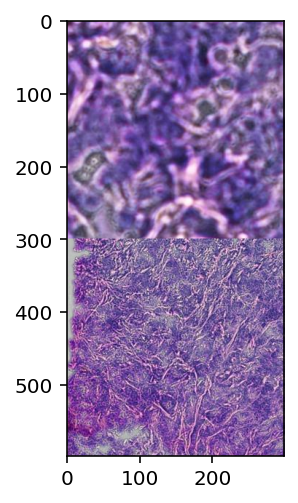

In [123]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])
img = cv2.vconcat([image1[0], image2[0]]).astype(np.uint8)
plt.imshow(img)

  0%|          | 0/100 [00:00<?, ?it/s]

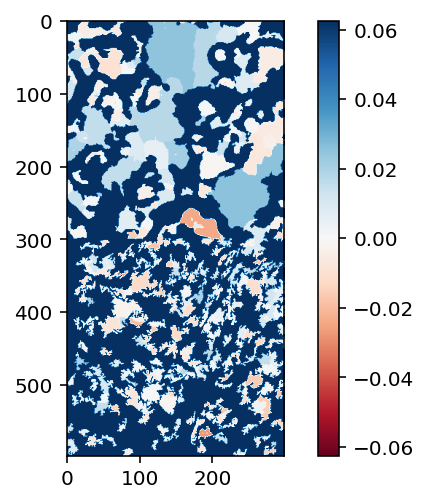

In [120]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])
img = cv2.vconcat([image1[0], image2[0]]).astype(np.uint8)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.astype('double'), model_predict_gene("COX6C"), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatm ap.max(), vmax = heatmap.max())
plt.colorbar()

  0%|          | 0/100 [00:00<?, ?it/s]

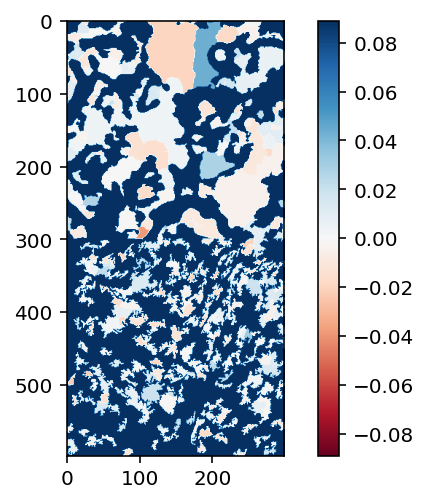

In [122]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])
img = cv2.vconcat([image1[0], image2[0]]).astype(np.uint8)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.astype('double'), model_predict_gene("CD74"), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# LIME 2 img

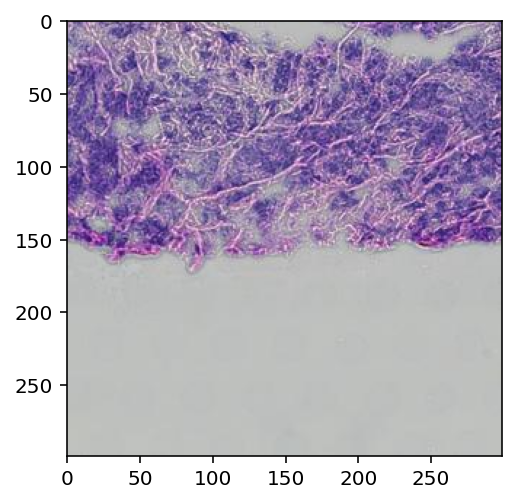

In [27]:
plt.imshow(Image.open('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-10258-21071-1950.jpeg'))

In [6]:
import cv2
gene_list = ["COX6C", "CD74"]
resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")


def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def model_predict_gene(gene, tile2):
    i = gene_list.index(gene)

    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        feature2 = resnet_model1.predict(tile2)
        feature = np.concatenate((feature1, feature2), axis=1)
        prediction = model_c.predict_proba(feature)
        return prediction[i]
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

  0%|          | 0/100 [00:00<?, ?it/s]

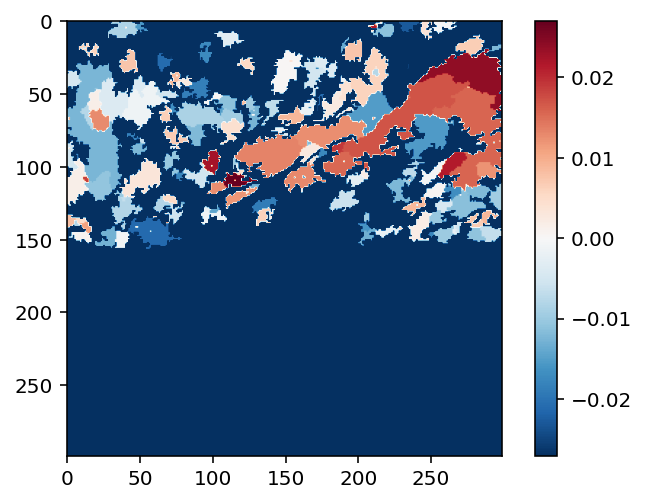

In [33]:
"""image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5091-14880-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5091-14880-1950.jpeg')])
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])"""


image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-10258-21071-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-10258-21071-1950.jpeg')])



explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image2[0].astype('double'), classifier_fn = model_predict_gene("CD74", image1.astype('double')), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu_r', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

  0%|          | 0/100 [00:00<?, ?it/s]

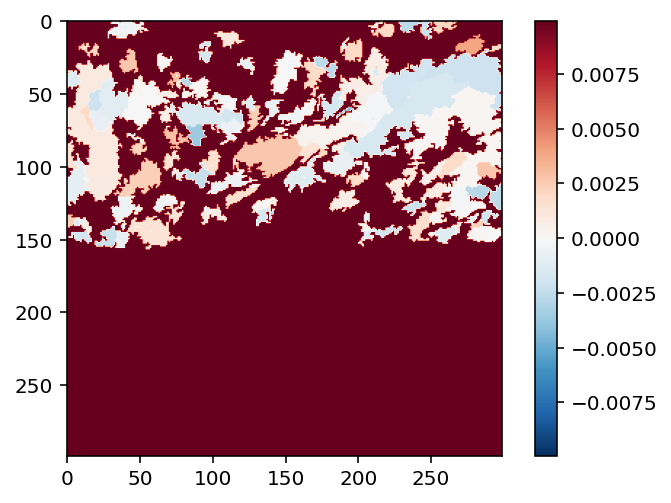

In [34]:
"""image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5091-14880-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5091-14880-1950.jpeg')])
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])
"""


image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-10258-21071-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-10258-21071-1950.jpeg')])



explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image2[0].astype('double'), classifier_fn = model_predict_gene("COX6C", image1.astype('double')), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu_r', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


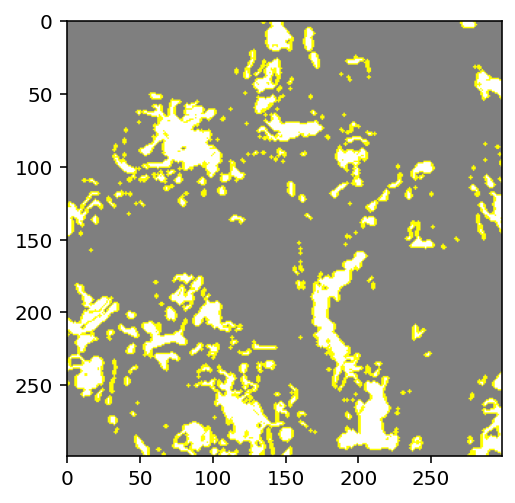

In [26]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-4953-15118-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-4953-15118-1950.jpeg')])
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(image1[0].astype('double'), image2[0].astype('double'), classifier_fn = model_predict_gene("CD74", image2.astype('double')), top_labels=2, hide_color=0, num_samples=100)
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=50, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image1[0].astype('double'), image2[0].astype('double'), classifier_fn = model_predict_gene("COX6C"), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

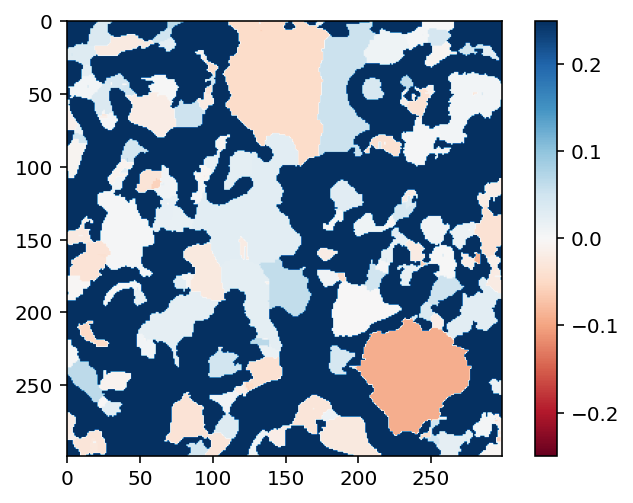

In [5]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\tiles\\block2\\block2-5759-19395-299.jpeg')])
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\big_tiles\\block2\\block2-5759-19395-1950.jpeg')])

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image1[0].astype('double'), image2[0].astype('double'), classifier_fn = model_predict_gene("CD74", image2.astype('double')), segmentation_fn = watershed_segment, top_labels=2, num_samples=100)#, image2.astype('double')
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()